## **Data Collection - Polygon.io Integration**

**Purpose:** Load and validate raw data from Polygon.io

**What it does:**

- Loads historical trade tick data and minute aggregate bars from Polygon.io
- Performs data quality checks (missing values, timestamps, gaps)
- Cleans and saves processed data to `data/interim/`
- Basic exploratory data analysis (EDA) to understand the data

**Data Sources (Developer Tier):**

- **Trades**: Individual trade tick data from `/v3/trades/{ticker}` ✓ Available
- **Aggregates**: Minute OHLCV bars from `/v2/aggs` ✓ Available
- **Quotes**: NBBO quote data Must be recorded via WebSocket (15-min delayed)
- **LOB**: L2 order book snapshots ✗ Not available

**Current Status:**

- Working with: Trades + Aggregates
- Future work: Add recorded NBBO quotes for trade classification


In [1]:
# ============================================================================
# 00_data_collection.ipynb
# Purpose: Load and validate raw data from Polygon.io
# ============================================================================

# %% Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

# Visualization settings
plt.style.use('seaborn-v0_8-paper')  
plt.rcParams.update({
    'font.family': 'serif',
    'font.weight': 'bold',        
    'axes.labelweight': 'bold',    
    'axes.titleweight': 'bold',   
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
})
%matplotlib inline

from src.config import RAW_DATA_DIR, INTERIM_DATA_DIR, FIGURES_DIR
from src.data.polygon_trade_loader import load_polygon_trades, PolygonTradeLoader
from src.data.polygon_quote_loader import load_polygon_quotes, PolygonQuoteLoader
from src.data.polygon_lob_loader import load_polygon_lob, PolygonLOBLoader
from src.data.polygon_aggregate_loader import load_polygon_aggregates, PolygonAggregateLoader
from src.data.synchronizer import align_trades_quotes
from src.utils.data_quality import (
    check_data_quality,
    print_quality_report,
    detect_gaps,
    remove_outliers
)

In [2]:
# %% Configuration
TICKER = "AAPL"  # U.S. equity ticker
START_DATE = "2024-12-09"  # Start date for multi-day data
END_DATE = "2024-12-13"  # End date for multi-day data
DATE_RANGE = f"{START_DATE}_to_{END_DATE}"  # File naming convention

# Data source selection
DATA_SOURCE = "local"  # "local" = load from disk, "api" = fetch from Polygon.io

print(f"Ticker: {TICKER}")
print(f"Date range: {START_DATE} to {END_DATE}")
print(f"Data source: {DATA_SOURCE}")

Ticker: AAPL
Date range: 2024-12-09 to 2024-12-13
Data source: local


In [3]:
# %% Note about data collection
# To collect new historical data from Polygon.io, use:
#
# python scripts/download_polygon_data.py --ticker AAPL --start-date 2024-12-09 --end-date 2024-12-13 --data-type all
#
# This will download:
# - Trade tick data → data/raw/polygon_trades/
# - Minute aggregate bars → data/raw/polygon_aggregates/
#
# To record real-time 15-min delayed NBBO quotes, use:
# python scripts/record_realtime_quotes.py --ticker AAPL
#
# This notebook assumes data has already been downloaded and saved to disk.

In [4]:
# %% Load data from Polygon.io

print("\n" + "=" * 60)
print("LOADING POLYGON.IO DATA")
print("=" * 60)

# Load trade data
print("\n1. Loading trade data...")
try:
    trades_file = (
        RAW_DATA_DIR / "polygon_trades" / f"{TICKER}_{DATE_RANGE}_trades.parquet"
    )

    if trades_file.exists():
        trades_df = pd.read_parquet(trades_file)
        print(f"   ✓ Loaded {len(trades_df):,} trades from {trades_file}")
        print(f"   Columns: {trades_df.columns.tolist()}")

        # Ensure timestamp is datetime
        if "timestamp" in trades_df.columns:
            trades_df["timestamp"] = pd.to_datetime(trades_df["timestamp"], utc=True)
    else:
        print(f"   ⚠️  File not found: {trades_file}")
        trades_df = None
except Exception as e:
    print(f"   ✗ Error loading trades: {e}")
    trades_df = None

# Load aggregate data (minute bars)
print("\n2. Loading aggregate bars...")
try:
    agg_file = (
        RAW_DATA_DIR
        / "polygon_aggregates"
        / f"{TICKER}_{DATE_RANGE}_1minute_bars.parquet"
    )

    if agg_file.exists():
        aggregates_df = pd.read_parquet(agg_file)
        print(f"   ✓ Loaded {len(aggregates_df):,} minute bars from {agg_file}")
        print(f"   Columns: {aggregates_df.columns.tolist()}")

        # Ensure timestamp is datetime
        if "timestamp" in aggregates_df.columns:
            aggregates_df["timestamp"] = pd.to_datetime(
                aggregates_df["timestamp"], utc=True
            )
    else:
        print(f"   ⚠️  File not found: {agg_file}")
        aggregates_df = None
except Exception as e:
    print(f"   ✗ Error loading aggregates: {e}")
    aggregates_df = None

# Note about quotes and LOB
print("\n3. Quote and LOB data status...")
print("   Historical NBBO quotes: Not available with Developer tier")
print("   Will record 15-min delayed quotes via WebSocket later")
print("   L2 LOB snapshots: Not available with Developer tier")
quotes_df = None
lob_df = None

print("\n" + "=" * 60)
print(
    f"Loaded {2 if (trades_df is not None and aggregates_df is not None) else (1 if (trades_df is not None or aggregates_df is not None) else 0)} out of 2 available datasets"
)
print("=" * 60)


LOADING POLYGON.IO DATA

1. Loading trade data...
   ✓ Loaded 342,282 trades from /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/data/raw/polygon_trades/AAPL_2024-12-09_to_2024-12-13_trades.parquet
   Columns: ['timestamp', 'price', 'size', 'exchange', 'conditions', 'trade_id', 'participant_timestamp']

2. Loading aggregate bars...
   ✓ Loaded 3,591 minute bars from /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/data/raw/polygon_aggregates/AAPL_2024-12-09_to_2024-12-13_1minute_bars.parquet
   Columns: ['volume', 'vwap', 'open', 'close', 'high', 'low', 'timestamp', 'trades', 'estimated_spread', 'mid_price', 'relative_spread', 'typical_price']

3. Quote and LOB data status...
   Historical NBBO quotes: Not available with Developer tier
   Will record 15-min delayed quotes via WebSocket later
   L2 LOB snapshots: Not available with Developer tier

Loaded 2 out of 2 available datasets


In [5]:
# %% Inspect quote data (NBBO)
print("\n" + "=" * 60)
print("QUOTE DATA INSPECTION (NBBO)")
print("=" * 60)

if quotes_df is not None:
    display(quotes_df.head())
    print(f"\nShape: {quotes_df.shape}")
    print(f"\nData types:\n{quotes_df.dtypes}")
    print(f"\nSample statistics:")
    print(quotes_df[["bid_price", "ask_price", "bid_size", "ask_size"]].describe())
else:
    print("No quote data available")


QUOTE DATA INSPECTION (NBBO)
No quote data available


In [6]:
# %% Inspect aggregate data (minute bars)
print("\n" + "=" * 60)
print("AGGREGATE DATA INSPECTION (MINUTE BARS)")
print("=" * 60)

if aggregates_df is not None:
    display(aggregates_df.head())
    print(f"\nShape: {aggregates_df.shape}")
    print(f"\nData types:\n{aggregates_df.dtypes}")
    print(f"\nSample statistics:")
    print(aggregates_df[["open", "high", "low", "close", "volume"]].describe())

    if "estimated_spread" in aggregates_df.columns:
        print(f"\nSpread statistics:")
        print(f"  Average spread: ${aggregates_df['estimated_spread'].mean():.4f}")
        if "relative_spread" in aggregates_df.columns:
            avg_spread_bps = aggregates_df["relative_spread"].mean() * 10000
            print(f"  Average spread (bps): {avg_spread_bps:.2f}")
else:
    print("No aggregate data available")


AGGREGATE DATA INSPECTION (MINUTE BARS)


,volume,vwap,open,close,high,low,timestamp,trades,estimated_spread,mid_price,relative_spread,typical_price
0,2214.0,242.7459,242.69,242.71,242.84,242.66,2024-12-09 09:00:00+00:00,93,0.18,242.750,0.000742,242.736667
1,1996.0,242.6163,242.64,242.58,242.64,242.55,2024-12-09 09:01:00+00:00,99,0.09,242.595,0.000371,242.590000
2,4327.0,242.6368,242.53,242.66,242.68,242.53,2024-12-09 09:02:00+00:00,99,0.15,242.605,0.000618,242.623333
3,1202.0,242.8080,242.79,242.78,242.79,242.78,2024-12-09 09:03:00+00:00,151,0.01,242.785,0.000041,242.783333
4,853.0,242.6653,242.74,242.63,242.74,242.63,2024-12-09 09:04:00+00:00,57,0.11,242.685,0.000453,242.666667



Shape: (3591, 12)

Data types:
volume                          float64
vwap                            float64
open                            float64
close                           float64
high                            float64
low                             float64
timestamp           datetime64[ns, UTC]
trades                            int64
estimated_spread                float64
mid_price                       float64
relative_spread                 float64
typical_price                   float64
dtype: object

Sample statistics:
              open         high          low        close        volume
count  3591.000000  3591.000000  3591.000000  3591.000000  3.591000e+03
mean    247.229781   247.281065   247.177943   247.230385  4.082988e+04
std       1.494282     1.495294     1.491499     1.492060  8.777101e+04
min     241.810000   241.887300   241.570000   241.830000  1.000000e+02
25%     246.720000   246.770000   246.663500   246.720000  1.125000e+03
50%     247.360000   2

In [7]:
# %% Inspect trade data
print("\n" + "=" * 60)
print("TRADE DATA INSPECTION")
print("=" * 60)

if trades_df is not None:
    display(trades_df.head())
    print(f"\nShape: {trades_df.shape}")
    print(f"\nData types:\n{trades_df.dtypes}")
    print(f"\nTrade statistics:")
    print(trades_df[["price", "size"]].describe())

    # Check trade classification if available
    if "is_aggressive_buy" in trades_df.columns:
        n_buys = trades_df["is_aggressive_buy"].sum()
        n_sells = trades_df["is_aggressive_sell"].sum()
        print(f"\nTrade classification:")
        print(f"  Aggressive buys: {n_buys:,} ({n_buys/len(trades_df)*100:.1f}%)")
        print(f"  Aggressive sells: {n_sells:,} ({n_sells/len(trades_df)*100:.1f}%)")
else:
    print("No trade data available")


TRADE DATA INSPECTION


,timestamp,price,size,exchange,conditions,trade_id,participant_timestamp
0,2024-12-09 09:00:00.035721709+00:00,242.69,295,11,"[12, 41]",1,2024-12-09 09:00:00.035358774
1,2024-12-09 09:00:00.053725025+00:00,242.72,100,8,[12],21,2024-12-09 09:00:00.049645000
2,2024-12-09 09:00:00.526138856+00:00,242.84,146,11,[12],13,2024-12-09 09:00:00.525783094
3,2024-12-09 09:00:00.526276091+00:00,242.83,100,11,[12],14,2024-12-09 09:00:00.525905429
4,2024-12-09 09:00:03.061727415+00:00,242.66,100,8,[12],31,2024-12-09 09:00:03.061514000



Shape: (342282, 7)

Data types:
timestamp                datetime64[ns, UTC]
price                                float64
size                                   int64
exchange                               int64
conditions                            object
trade_id                              object
participant_timestamp         datetime64[ns]
dtype: object

Trade statistics:
               price          size
count  342282.000000  3.422820e+05
mean      247.362369  2.872549e+02
std         1.386459  6.692158e+03
min       230.380200  1.000000e+02
25%       246.570000  1.000000e+02
50%       247.380000  1.000000e+02
75%       248.140000  2.000000e+02
max       264.147200  1.746670e+06


In [8]:
# %% Inspect LOB data (L2 snapshots)
print("\n" + "=" * 60)
print("ORDER BOOK DATA INSPECTION (L2)")
print("=" * 60)

if lob_df is not None:
    display(lob_df.head())
    print(f"\nShape: {lob_df.shape}")
    print(f"\nData types:\n{lob_df.dtypes.head(20)}")

    # Check for computed features
    if "quoted_spread" in lob_df.columns:
        print(f"\nOrder book statistics:")
        print(f"  Average spread: ${lob_df['quoted_spread'].mean():.4f}")
        if "relative_spread" in lob_df.columns:
            print(
                f"  Average spread (bps): {lob_df['relative_spread'].mean()*10000:.2f}"
            )
        if "depth_at_best" in lob_df.columns:
            print(
                f"  Average depth at best: {lob_df['depth_at_best'].mean():.0f} shares"
            )
else:
    print("No LOB data available")


ORDER BOOK DATA INSPECTION (L2)
No LOB data available


In [9]:
# %% Data quality checks
print("\n" + "=" * 60)
print("DATA QUALITY ANALYSIS")
print("=" * 60)

# Check aggregate data quality
if aggregates_df is not None:
    print("\nChecking aggregate data quality...")
    quality_report = check_data_quality(aggregates_df, timestamp_col="timestamp")
    print_quality_report(quality_report)
else:
    print("No aggregate data available for quality checks")

# Check trade data quality
if trades_df is not None:
    print("\n\nChecking trade data quality...")
    quality_report = check_data_quality(trades_df, timestamp_col="timestamp")
    print_quality_report(quality_report)


DATA QUALITY ANALYSIS

Checking aggregate data quality...
DATA QUALITY REPORT

 Basic Info:
  Rows: 3,591
  Columns: 12
  Duplicates: 0

 Missing Values:
 No missing values

 Timestamp Info:
  Start: 2024-12-09 09:00:00+00:00
  End: 2024-12-14 00:58:00+00:00
  Duration: 111.97 hours
  Median gap: 60.00s
  Max gap: 28860.00s



Checking trade data quality...
DATA QUALITY REPORT

 Basic Info:
  Rows: 342,282
  Columns: 7
  Duplicates: 0

 Missing Values:
  conditions: 323310 (94.46%)

 Timestamp Info:
  Start: 2024-12-09 09:00:00.035721709+00:00
  End: 2024-12-14 00:58:26.219058001+00:00
  Duration: 111.97 hours
  Median gap: 0.03s
  Max gap: 28839.66s



In [10]:
# %% Check for time gaps
print("\n" + "=" * 60)
print("TIME GAP ANALYSIS")
print("=" * 60)

# Check gaps in aggregate data (should be continuous minute bars during market hours)
if aggregates_df is not None:
    print("\nAnalyzing gaps in aggregate data...")
    gaps = detect_gaps(aggregates_df, timestamp_col="timestamp", max_gap_seconds=120.0)
    if len(gaps) > 0:
        print(f"   Found {len(gaps)} gaps > 120s:")
        display(gaps.head())
    else:
        print("   No significant time gaps found in minute bars")

# Check gaps in trade data
if trades_df is not None:
    print("\nAnalyzing gaps in trade data...")
    gaps = detect_gaps(trades_df, timestamp_col="timestamp", max_gap_seconds=300.0)
    if len(gaps) > 0:
        print(f"   Found {len(gaps)} gaps > 300s:")
        display(gaps.head())
    else:
        print("   No significant time gaps found in trades")


TIME GAP ANALYSIS

Analyzing gaps in aggregate data...
Found 261 gaps > 120.0s
Total gap time: 189060s
Max gap: 28860s
   Found 261 gaps > 120s:


,gap_start,gap_end,duration_seconds,index_before,index_after
0,2024-12-09 09:20:00+00:00,2024-12-09 09:23:00+00:00,180.0,17,18
1,2024-12-09 09:29:00+00:00,2024-12-09 09:34:00+00:00,300.0,24,25
2,2024-12-09 09:35:00+00:00,2024-12-09 09:39:00+00:00,240.0,26,27
3,2024-12-09 09:46:00+00:00,2024-12-09 09:49:00+00:00,180.0,32,33
4,2024-12-09 09:49:00+00:00,2024-12-09 09:52:00+00:00,180.0,33,34



Analyzing gaps in trade data...
Found 98 gaps > 300.0s
Total gap time: 161365s
Max gap: 28840s
   Found 98 gaps > 300s:


,gap_start,gap_end,duration_seconds,index_before,index_after
0,2024-12-09 09:46:57.377515512+00:00,2024-12-09 09:52:32.312855130+00:00,334.935339,95,96
1,2024-12-09 10:28:32.291760189+00:00,2024-12-09 10:38:44.348008604+00:00,612.056248,140,141
2,2024-12-09 10:38:44.348039175+00:00,2024-12-09 10:48:35.752138798+00:00,591.404099,144,145
3,2024-12-09 10:53:50.136802916+00:00,2024-12-09 10:58:56.217311908+00:00,306.080508,152,153
4,2024-12-09 11:05:46.213599860+00:00,2024-12-09 11:16:27.991840860+00:00,641.778241,165,166



VISUALIZATIONS


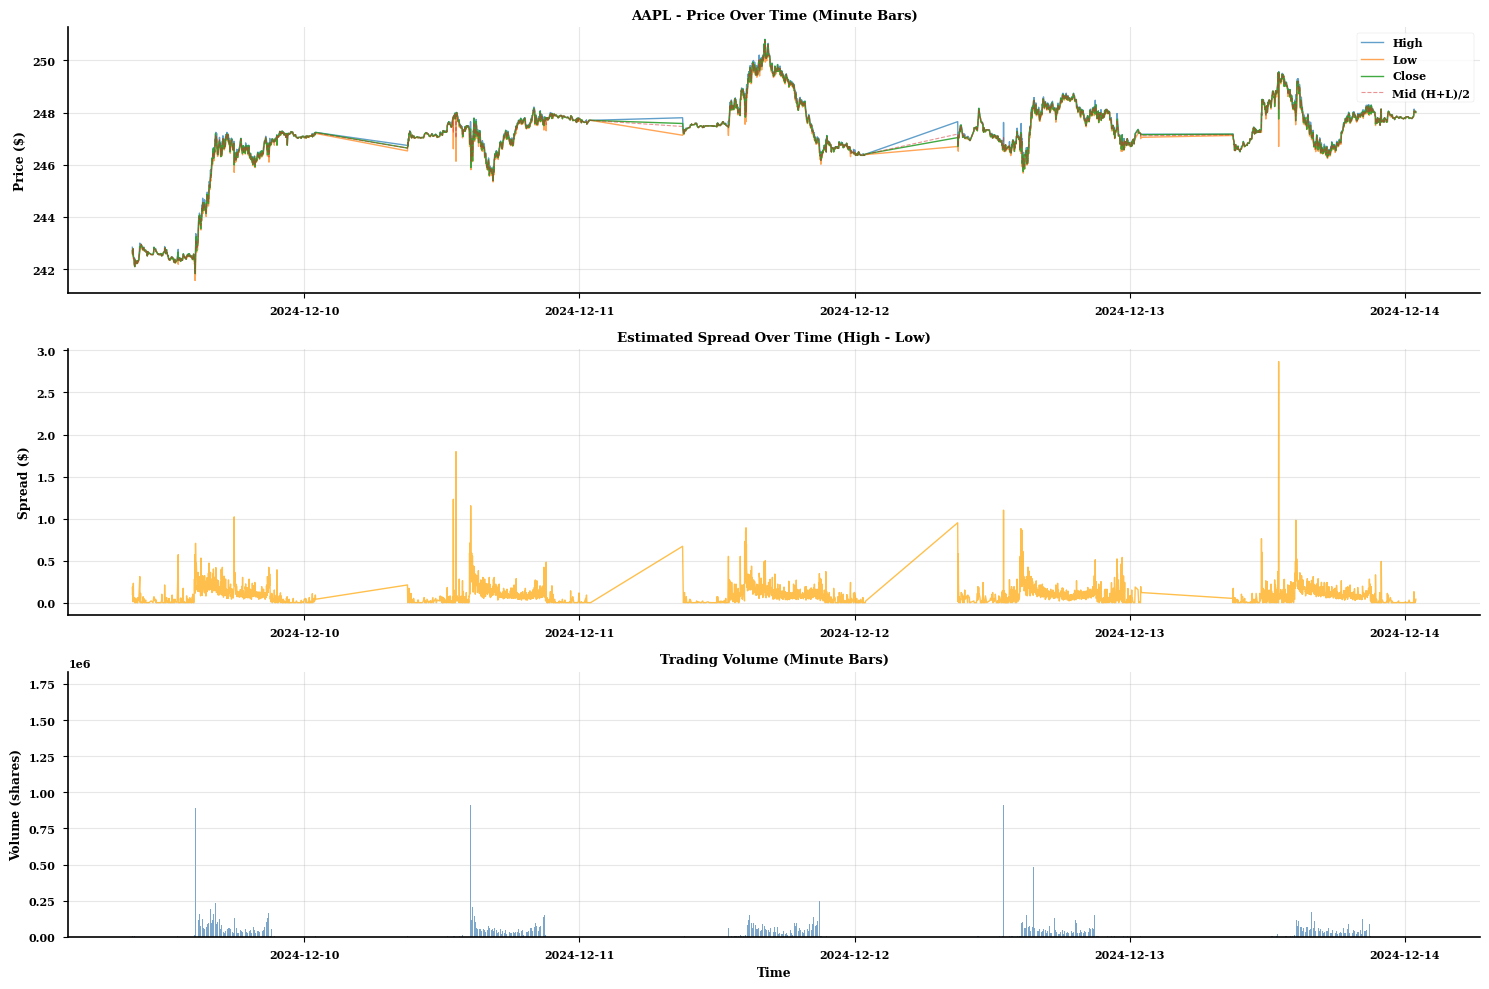


Saved visualization to: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/reports/figures/AAPL_aggregate_data_overview.png

Generating trade price scatter plot...


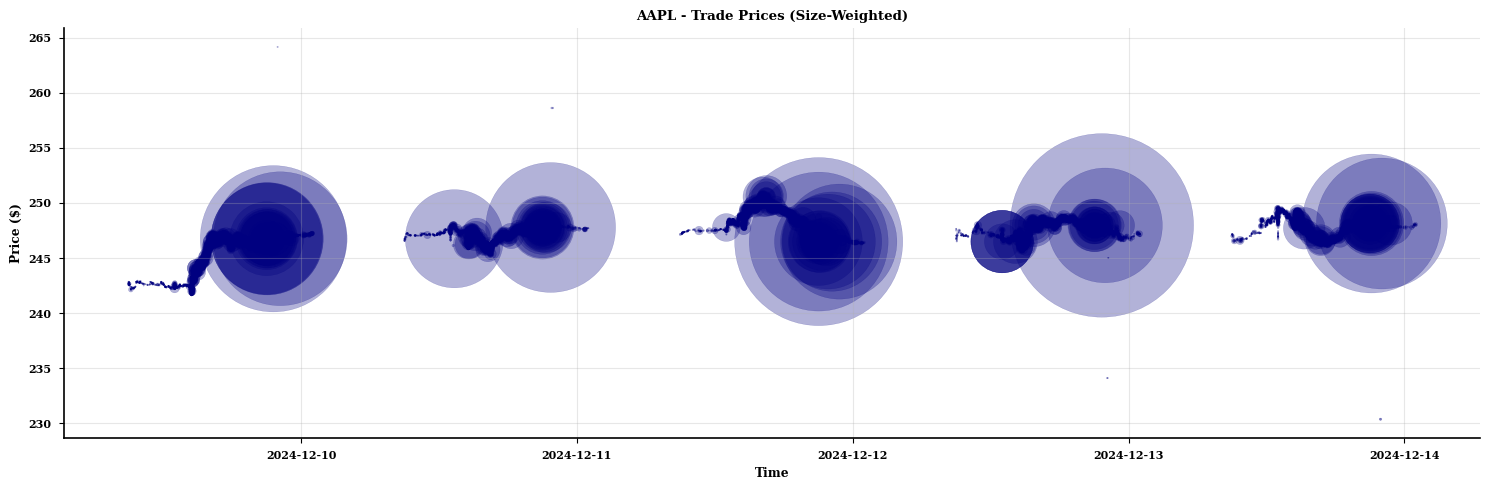

Saved visualization to: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/reports/figures/AAPL_trade_prices.png


In [11]:
# %% Visualize aggregate data
print("\n" + "=" * 60)
print("VISUALIZATIONS")
print("=" * 60)

if aggregates_df is not None and len(aggregates_df) > 0:
    fig, axes = plt.subplots(3, 1, figsize=(15, 10))

    # OHLC prices
    axes[0].plot(
        aggregates_df["timestamp"],
        aggregates_df["high"],
        label="High",
        linewidth=1.0,
        alpha=0.7,
    )
    axes[0].plot(
        aggregates_df["timestamp"],
        aggregates_df["low"],
        label="Low",
        linewidth=1.0,
        alpha=0.7,
    )
    axes[0].plot(
        aggregates_df["timestamp"],
        aggregates_df["close"],
        label="Close",
        linewidth=1.0,
        alpha=0.9,
    )
    if "mid_price" in aggregates_df.columns:
        axes[0].plot(
            aggregates_df["timestamp"],
            aggregates_df["mid_price"],
            label="Mid (H+L)/2",
            linewidth=0.8,
            alpha=0.5,
            linestyle="--",
        )
    axes[0].set_title(f"{TICKER} - Price Over Time (Minute Bars)")
    axes[0].set_ylabel("Price ($)")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Estimated spread (High - Low)
    if "estimated_spread" in aggregates_df.columns:
        spread = aggregates_df["estimated_spread"]
    else:
        spread = aggregates_df["high"] - aggregates_df["low"]
    axes[1].plot(
        aggregates_df["timestamp"], spread, linewidth=1.0, color="orange", alpha=0.7
    )
    axes[1].set_title("Estimated Spread Over Time (High - Low)")
    axes[1].set_ylabel("Spread ($)")
    axes[1].grid(True, alpha=0.3)

    # Volume
    axes[2].bar(
        aggregates_df["timestamp"],
        aggregates_df["volume"],
        width=0.0005,  # Adjust based on time scale
        alpha=0.7,
        color="steelblue",
    )
    axes[2].set_title("Trading Volume (Minute Bars)")
    axes[2].set_ylabel("Volume (shares)")
    axes[2].set_xlabel("Time")
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(
        FIGURES_DIR / f"{TICKER}_aggregate_data_overview.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()
    print(
        f"\nSaved visualization to: {FIGURES_DIR / f'{TICKER}_aggregate_data_overview.png'}"
    )

    # Also visualize trade data if available
    if trades_df is not None and len(trades_df) > 0:
        print("\nGenerating trade price scatter plot...")
        fig, ax = plt.subplots(1, 1, figsize=(15, 5))
        ax.scatter(
            trades_df["timestamp"],
            trades_df["price"],
            s=trades_df["size"] / 100,  # Size proportional to trade size
            alpha=0.3,
            c="navy",
        )
        ax.set_title(f"{TICKER} - Trade Prices (Size-Weighted)")
        ax.set_ylabel("Price ($)")
        ax.set_xlabel("Time")
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(
            FIGURES_DIR / f"{TICKER}_trade_prices.png", dpi=300, bbox_inches="tight"
        )
        plt.show()
        print(f"Saved visualization to: {FIGURES_DIR / f'{TICKER}_trade_prices.png'}")
else:
    print("No aggregate data available for visualization")

In [12]:
# %% Handle missing values and outliers
print("\n" + "=" * 60)
print("DATA CLEANING")
print("=" * 60)

# Clean aggregate data
if aggregates_df is not None:
    print("\nCleaning aggregate data...")
    print(f"  Before cleaning: {len(aggregates_df):,} rows")

    # Drop missing values
    aggregates_df_clean = aggregates_df.dropna()
    print(f"  After dropping NaN: {len(aggregates_df_clean):,} rows")

    # Remove outliers (optional - be conservative)
    price_cols = ["open", "high", "low", "close"]
    aggregates_df_clean = remove_outliers(
        aggregates_df_clean,
        columns=price_cols,
        method="iqr",
        threshold=3.0,
        verbose=True,
    )
    print(f"  After outlier removal: {len(aggregates_df_clean):,} rows")
else:
    aggregates_df_clean = None
    print("No aggregate data to clean")

# Clean trade data
if trades_df is not None:
    print("\nCleaning trade data...")
    print(f"  Before cleaning: {len(trades_df):,} rows")

    # Drop missing values
    trades_df_clean = trades_df.dropna()
    print(f"  After dropping NaN: {len(trades_df_clean):,} rows")

    # Remove outliers
    trades_df_clean = remove_outliers(
        trades_df_clean, columns=["price"], method="iqr", threshold=3.0, verbose=True
    )
    print(f"  After outlier removal: {len(trades_df_clean):,} rows")
else:
    trades_df_clean = None
    print("No trade data to clean")

# Note about quotes and LOB
quotes_df_clean = None
lob_df_clean = None
print("\nNote: Quote and LOB data not available (see loading section)")


DATA CLEANING

Cleaning aggregate data...
  Before cleaning: 3,591 rows
  After dropping NaN: 3,591 rows
  open: removing 183 outliers (5.10%)
    Bounds: [242.8800, 251.8400]
  high: removing 7 outliers (0.21%)
    Bounds: [243.1089, 251.8584]
  low: removing 4 outliers (0.12%)
    Bounds: [243.0150, 251.7300]

Total rows removed: 194 (5.40%)
Remaining rows: 3397
  After outlier removal: 3,397 rows

Cleaning trade data...
  Before cleaning: 342,282 rows
  After dropping NaN: 18,972 rows
  price: removing 567 outliers (2.99%)
    Bounds: [242.6314, 252.0449]

Total rows removed: 567 (2.99%)
Remaining rows: 18405
  After outlier removal: 18,405 rows

Note: Quote and LOB data not available (see loading section)


In [13]:
# %% Save cleaned data
print("\n" + "=" * 60)
print("SAVING CLEANED DATA")
print("=" * 60)

INTERIM_DATA_DIR.mkdir(parents=True, exist_ok=True)

# Save aggregate data
if aggregates_df_clean is not None:
    output_file = INTERIM_DATA_DIR / f"{TICKER}_aggregates_cleaned.parquet"
    aggregates_df_clean.to_parquet(output_file, index=False)
    print(f"\n✓ Saved cleaned aggregate data to: {output_file}")
    print(f"  File size: {output_file.stat().st_size / 1024 / 1024:.2f} MB")
    print(f"  Records: {len(aggregates_df_clean):,}")

# Save trade data
if trades_df_clean is not None:
    output_file = INTERIM_DATA_DIR / f"{TICKER}_trades_cleaned.parquet"
    trades_df_clean.to_parquet(output_file, index=False)
    print(f"\n✓ Saved cleaned trade data to: {output_file}")
    print(f"  File size: {output_file.stat().st_size / 1024 / 1024:.2f} MB")
    print(f"  Records: {len(trades_df_clean):,}")

# %% Summary
print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)

if aggregates_df_clean is not None:
    print(f"\n✓ Loaded {len(aggregates_df_clean):,} clean aggregate bars (minute)")
    print(
        f"  Time range: {aggregates_df_clean['timestamp'].min()} to {aggregates_df_clean['timestamp'].max()}"
    )
    if "estimated_spread" in aggregates_df_clean.columns:
        avg_spread = aggregates_df_clean["estimated_spread"].mean()
        avg_spread_bps = aggregates_df_clean["relative_spread"].mean() * 10000
        print(f"  Average spread: ${avg_spread:.4f} ({avg_spread_bps:.2f} bps)")

if trades_df_clean is not None:
    print(f"\n✓ Loaded {len(trades_df_clean):,} clean trades")
    print(
        f"  Time range: {trades_df_clean['timestamp'].min()} to {trades_df_clean['timestamp'].max()}"
    )

print(f"\n✓ Data saved to: {INTERIM_DATA_DIR}")
print(f"\n Current data status:")
print(f"   - Historical trades: Available")
print(f"   - Minute aggregates: Available")
print(f"   - NBBO quotes: Need to record via WebSocket")
print(f"   - L2 LOB snapshots: Not available with Developer tier")
print(f"\n Next notebook: Run 10_basic_features.ipynb")


SAVING CLEANED DATA

✓ Saved cleaned aggregate data to: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/data/interim/AAPL_aggregates_cleaned.parquet
  File size: 0.19 MB
  Records: 3,397

✓ Saved cleaned trade data to: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/data/interim/AAPL_trades_cleaned.parquet
  File size: 0.55 MB
  Records: 18,405

SUMMARY

✓ Loaded 3,397 clean aggregate bars (minute)
  Time range: 2024-12-09 14:45:00+00:00 to 2024-12-14 00:58:00+00:00
  Average spread: $0.1054 (4.26 bps)

✓ Loaded 18,405 clean trades
  Time range: 2024-12-09 09:00:00.035721709+00:00 to 2024-12-14 00:58:26.219058001+00:00

✓ Data saved to: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/data/interim

 Current data status:
   - Historical trades: Available
   - Minute aggregates: Available
   - NBBO quotes: Need to record via WebSocket
   - L2 LOB snapshots: Not available with Developer tier

 Next notebook: Run 10_basic_featu

In [ ]:
# %% Optional: Trade classification using Lee-Ready (future work)
print("\n" + "=" * 60)
print("TRADE CLASSIFICATION (FUTURE WORK)")
print("=" * 60)

print("\n Trade classification using Lee-Ready algorithm requires NBBO quotes")
print("   Current status:")
print("   - Trades: Available")
print("   - NBBO quotes: Will record via WebSocket later")
print("\n   Once quote data is available, we can:")
print("   1. Align trades with prevailing quotes (as-of merge)")
print("   2. Classify trades as aggressive buys/sells using Lee-Ready")
print("   3. Compute order flow imbalance features")
print("\n   For now, we can still work with:")
print("   - Trade size and price distributions")
print("   - Trade intensity and volume patterns")
print("   - Aggregate-based spread approximations")


TRADE CLASSIFICATION (FUTURE WORK)

ℹ️  Trade classification using Lee-Ready algorithm requires NBBO quotes
   Current status:
   - Trades: Available
   - NBBO quotes: Will record via WebSocket later

   Once quote data is available, we can:
   1. Align trades with prevailing quotes (as-of merge)
   2. Classify trades as aggressive buys/sells using Lee-Ready
   3. Compute order flow imbalance features

   For now, we can still work with:
   - Trade size and price distributions
   - Trade intensity and volume patterns
   - Aggregate-based spread approximations
